In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [69]:
import os
import datetime

#图像读取库
from PIL import Image
#矩阵运算库
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [70]:
# 分类
label_names = ["anger", "disgust", "fear", "happy", "sad"]
label_to_index = dict((name, index) for index, name in enumerate(label_names))

print(label_names)
print(label_to_index)

['anger', 'disgust', 'fear', 'happy', 'sad']
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4}


In [71]:
# 获取训练的图片列表和分类标签信息
def load_images(data_dir):
    fpaths = []
    labels = []
    
    for label in os.listdir(data_dir):
        labelPath = os.path.join(data_dir, label)
        for fname in os.listdir(labelPath):
            # 文件名
            fpath = os.path.join(labelPath, fname)
            fpaths.append(fpath)
            
            # 标签
            labels.append(label_to_index[label])
    
    # 将图片名和标签 打包成一组，然后进行乱序
    temp = np.array([fpaths,labels])
    temp = temp.transpose()
    np.random.shuffle(temp)

    fpaths = list(temp[:,0])
    labels = list(temp[:,1])
    labels = [int(i) for i in labels]
    
    return fpaths, labels

In [72]:
# 数据文件夹
data_dir = "/home/wilson/workstation/TFResFaceEmotion/emotions"

all_image_paths, all_image_labels = load_images(data_dir)

image_count = len(all_image_paths)
print("total", image_count, "images")

total 79 images


In [73]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    image /= 255.0
    #print(333, image.shape, image)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

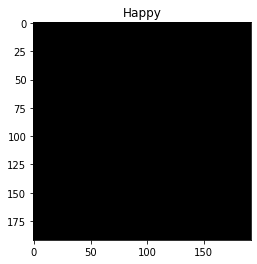

In [74]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

In [75]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

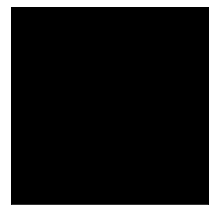

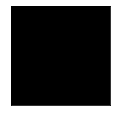

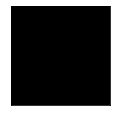

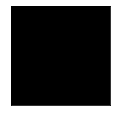

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [77]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])

happy
anger
anger
fear
anger
anger
fear
happy
anger
happy


In [78]:
# 由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

<ZipDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int32)>


In [79]:
"""训练的基本方法
要使用此数据集训练模型，你将会想要数据：

    被充分打乱。
    被分割为 batch。
    永远重复。
    尽快提供 batch。

使用 tf.data api 可以轻松添加这些功能。
"""
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>


In [80]:
# 现在准备分类模型
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False


In [81]:
# 该模型期望它的输出被标准化至 [-1,1] 范围内：
# help(tf.keras.applications.mobilenet_v2.preprocess_input)


In [82]:
# 在你将输出传递给 MobilNet 模型之前，你需要将其范围从 [0,1] 转化为 [-1,1]：
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)


(32, 6, 6, 1280)


In [83]:
# 模型保存位置
model_save_path = 'emotion.model'

# 模型
model = None
if os.path.exists(model_save_path):
    model = keras.models.load_model(model_save_path)
else:
    model = tf.keras.Sequential([
        mobile_net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(label_names), activation='softmax')])

In [84]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.054046214
max logit: 0.4372469

Shape: (32, 5)


In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])


In [86]:
len(model.trainable_variables)


2

In [87]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [88]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

3.0

In [93]:
# Clear any logs from previous runs
# 清除旧的log
# !rm -rf ./logs/

# 日志统计回调
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [96]:
# 执行训练
model.fit(ds, epochs=10, steps_per_epoch=30000, 
         callbacks=[tensorboard_callback])
print("train done.")

# 保存模型
model.save(model_save_path)
print("model saved to", model_save_path)

# %load_ext tensorboard
%tensorboard --logdir logs/fit

Epoch 1/10
30000/30000 [==============================] - 580s 19ms/step - loss: 1.0229 - accuracy: 0.6682
Epoch 2/10
30000/30000 [==============================] - 582s 19ms/step - loss: 0.8968 - accuracy: 0.7327
Epoch 3/10
30000/30000 [==============================] - 578s 19ms/step - loss: 0.8045 - accuracy: 0.7675
Epoch 4/10
30000/30000 [==============================] - 582s 19ms/step - loss: 0.7311 - accuracy: 0.7911
Epoch 5/10
30000/30000 [==============================] - 582s 19ms/step - loss: 0.6697 - accuracy: 0.8225
Epoch 6/10
30000/30000 [==============================] - 582s 19ms/step - loss: 0.6168 - accuracy: 0.8559
Epoch 7/10
30000/30000 [==============================] - 582s 19ms/step - loss: 0.5699 - accuracy: 0.8785
Epoch 8/10
30000/30000 [==============================] - 577s 19ms/step - loss: 0.5279 - accuracy: 0.8979
Epoch 9/10
30000/30000 [==============================] - 573s 19ms/step - loss: 0.4900 - accuracy: 0.9159
Epoch 10/10
30000/30000 [============

Reusing TensorBoard on port 6006 (pid 5015), started 2:08:48 ago. (Use '!kill 5015' to kill it.)

In [2]:
# 使用命令转换 模型到tfile
# 下列命令参数用于输入和输出文件。
#    --output_file. 类型: string. 指定输出文件的绝对路径。
#    --saved_model_dir. 类型: string. 指定含有 TensorFlow 1.x 或者 2.0 使用 SavedModel 生成文件的绝对路径目录。
#    --keras_model_file. Type: string. 指定含有 TensorFlow 1.x 或者 2.0 使用 tf.keras model 生成 HDF5 文件的绝对路径目录。
#例如： tflite_convert --saved_model_dir=./emotion.model --output_file=./emotion.tflite